In [82]:
import math
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import matplotlib.dates as mdates
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
#from sklearn.cross_validation import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score
from datetime import timedelta

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
#from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Dropout

In [83]:
df = pd.read_csv('../input/teresopolis-2016-2023-precos-medios.csv', sep=',', 
                 parse_dates={'dt' : ['Ano', 'Mês', 'Dia']},
                 low_memory=False, na_values=['nan','?'], index_col='dt')

#filtra produto 'Alface Crespa - Roça', mantendo a coluna Preco_unitario
filtered_alface_crespa_roca = df[df['Produto'] == 'Alface Crespa - Roça'][['Preco_unitario']]
#agrupa por semana
filtered_alface_crespa_roca = filtered_alface_crespa_roca.resample('W').mean()
#preenche valores faltantes usando interpolação linear
filtered_alface_crespa_roca = filtered_alface_crespa_roca.interpolate(method='linear')
filtered_alface_crespa_roca.index = filtered_alface_crespa_roca.index.tz_localize("UTC")#.tz_convert("America/Sao_Paulo")
#identifica cada semana
#filtered_alface_crespa_roca['week'] = filtered_alface_crespa_roca.index.strftime('%Y-w%V')
#ordena por data
filtered_alface_crespa_roca.sort_values(by=['dt'], inplace=True)

filtered_alface_crespa_roca["first_day_week"] = filtered_alface_crespa_roca.index - filtered_alface_crespa_roca.index.weekday * timedelta(days=1)
filtered_alface_crespa_roca

,Preco_unitario,first_day_week
dt,,
2016-04-24 00:00:00+00:00,0.61650,2016-04-18 00:00:00+00:00
2016-05-01 00:00:00+00:00,0.42611,2016-04-25 00:00:00+00:00
2016-05-08 00:00:00+00:00,0.43778,2016-05-02 00:00:00+00:00
2016-05-15 00:00:00+00:00,0.43056,2016-05-09 00:00:00+00:00
2016-05-22 00:00:00+00:00,0.44444,2016-05-16 00:00:00+00:00
...,...,...
2023-08-27 00:00:00+00:00,0.40833,2023-08-21 00:00:00+00:00
2023-09-03 00:00:00+00:00,0.37500,2023-08-28 00:00:00+00:00
2023-09-10 00:00:00+00:00,0.35417,2023-09-04 00:00:00+00:00


In [84]:
weather_df = pd.read_csv('../processed_data/weather_2016_2023.csv', index_col=0)
weather_df.index = pd.to_datetime(weather_df.index, utc=True)

for col in weather_df.columns:
    weather_df[col] = weather_df[col].replace(-9999, None)
	
weather_df = weather_df[(weather_df.index >= '2016-04-24') & (weather_df.index <= '2023-09-24')]
weather_weekly_df = pd.DataFrame(weather_df[[ 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 'RADIACAO GLOBAL (Kj/m²)']].resample('W').mean())
#weather_weekly_df = weather_df
#weather_weekly_df['week'] = weather_weekly_df.index.strftime('%Y-w%V')
weather_weekly_df["first_day_week"] = (weather_weekly_df.index - weather_weekly_df.index.weekday * timedelta(days=1))

,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)",RADIACAO GLOBAL (Kj/m²)
dt,,
2016-04-24 00:00:00+00:00,0.0,1626.1
2016-05-01 00:00:00+00:00,0.145238,682.220238
2016-05-08 00:00:00+00:00,0.021429,1086.82561
2016-05-15 00:00:00+00:00,0.215476,662.45
2016-05-22 00:00:00+00:00,0.115476,782.577108
...,...,...
2023-08-27 00:00:00+00:00,0.464286,523.641667
2023-09-03 00:00:00+00:00,0.172619,501.019048
2023-09-10 00:00:00+00:00,0.395238,652.449405


<Axes: xlabel='dt'>

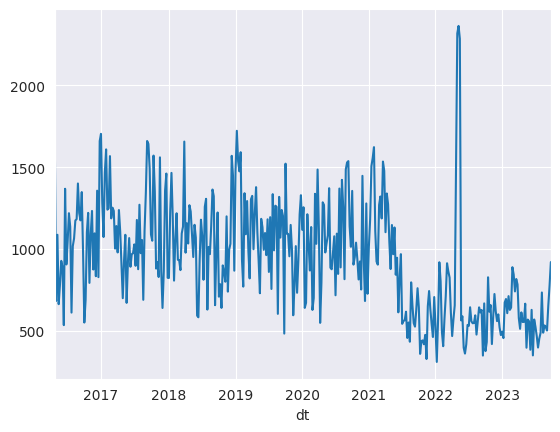

In [87]:
weather_weekly_df['RADIACAO GLOBAL (Kj/m²)'].plot()

<Axes: xlabel='dt'>

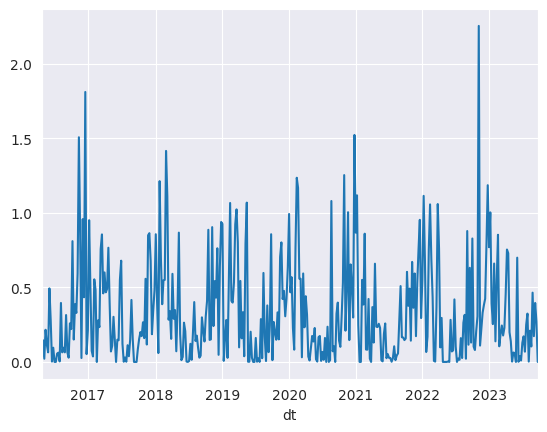

In [88]:
weather_weekly_df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].plot()

In [91]:
price_weather_df = pd.merge(filtered_alface_crespa_roca, weather_weekly_df, on='first_day_week', how='left')
price_weather_df

,Preco_unitario,first_day_week,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)",RADIACAO GLOBAL (Kj/m²)
0,0.61650,2016-04-18 00:00:00+00:00,0.0,1626.1
1,0.42611,2016-04-25 00:00:00+00:00,0.145238,682.220238
2,0.43778,2016-05-02 00:00:00+00:00,0.021429,1086.82561
3,0.43056,2016-05-09 00:00:00+00:00,0.215476,662.45
4,0.44444,2016-05-16 00:00:00+00:00,0.115476,782.577108
...,...,...,...,...
383,0.40833,2023-08-21 00:00:00+00:00,0.464286,523.641667
384,0.37500,2023-08-28 00:00:00+00:00,0.172619,501.019048
385,0.35417,2023-09-04 00:00:00+00:00,0.395238,652.449405
386,0.33333,2023-09-11 00:00:00+00:00,0.271429,775.36131


<Axes: xlabel='dt'>

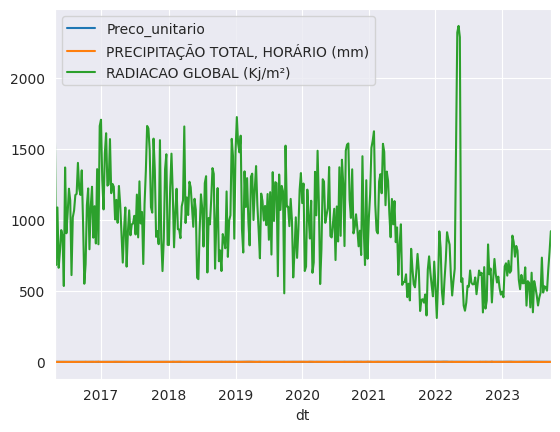

In [92]:
price_weather_df.index = filtered_alface_crespa_roca.index

price_weather_df[['Preco_unitario', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 'RADIACAO GLOBAL (Kj/m²)']].plot()


## Dividir os dados e descobrir como colocar as tranformações todas num pipeline

In [ ]:

price_weather_numeric_df = price_weather_df[['Preco_unitario', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 'RADIACAO GLOBAL (Kj/m²)']]
price_precipitation = price_weather_numeric_df[['Preco_unitario', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)']]
prediction_values = price_precipitation.values
dataset_size = len(prediction_values)

In [134]:
price_precipitation

,Preco_unitario,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"
dt,,
2016-04-24 00:00:00+00:00,0.61650,0.0
2016-05-01 00:00:00+00:00,0.42611,0.145238
2016-05-08 00:00:00+00:00,0.43778,0.021429
2016-05-15 00:00:00+00:00,0.43056,0.215476
2016-05-22 00:00:00+00:00,0.44444,0.115476
...,...,...
2023-08-27 00:00:00+00:00,0.40833,0.464286
2023-09-03 00:00:00+00:00,0.37500,0.172619
2023-09-10 00:00:00+00:00,0.35417,0.395238


In [97]:
train_size = math.ceil(dataset_size * 0.7)
test_size = math.ceil(dataset_size * 0.2)
validation_size = dataset_size - train_size - test_size
print(f"train_size: {train_size}\nvalidation_size: {validation_size}\ntest_size: {test_size}")

train_size: 272
validation_size: 38
test_size: 78


In [99]:
values_train = prediction_values[0:train_size]
values_validation = prediction_values[train_size:train_size+validation_size]
values_test = prediction_values[train_size+validation_size:dataset_size]
print(f"values_train: {values_train.shape}\nvalues_validation: {values_validation.shape}\nvalues_test: {values_test.shape}")

values_train: (272, 2)
values_validation: (38, 2)
values_test: (78, 2)


In [101]:

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(values_train)
scaled_validation = scaler.transform(values_validation)
scaled_test = scaler.transform(values_test)


In [102]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [103]:
in_size = 8
out_size = 8

reframed_train = series_to_supervised(scaled_train, in_size, out_size)
reframed_validation = series_to_supervised(scaled_validation, in_size, out_size)
reframed_test = series_to_supervised(scaled_test, in_size, out_size)
reframed_train

,var1(t-8),var2(t-8),var1(t-7),var2(t-7),var1(t-6),var2(t-6),var1(t-5),var2(t-5),var1(t-4),var2(t-4),...,var1(t+3),var2(t+3),var1(t+4),var2(t+4),var1(t+5),var2(t+5),var1(t+6),var2(t+6),var1(t+7),var2(t+7)
8,0.516188,0.000000,0.286954,0.080263,0.301005,0.011842,0.292312,0.119079,0.309024,0.063816,...,0.253507,0.000000,0.242141,0.030921,0.220071,0.034211,0.186623,0.001974,0.191969,0.218421
9,0.286954,0.080263,0.301005,0.011842,0.292312,0.119079,0.309024,0.063816,0.320402,0.035526,...,0.242141,0.030921,0.220071,0.034211,0.186623,0.001974,0.191969,0.218421,0.130432,0.035526
10,0.301005,0.011842,0.292312,0.119079,0.309024,0.063816,0.320402,0.035526,0.200662,0.272368,...,0.220071,0.034211,0.186623,0.001974,0.191969,0.218421,0.130432,0.035526,0.130432,0.052632
11,0.292312,0.119079,0.309024,0.063816,0.320402,0.035526,0.200662,0.272368,0.153176,0.155263,...,0.186623,0.001974,0.191969,0.218421,0.130432,0.035526,0.130432,0.052632,0.130432,0.035526
12,0.309024,0.063816,0.320402,0.035526,0.200662,0.272368,0.153176,0.155263,0.710373,0.001316,...,0.191969,0.218421,0.130432,0.035526,0.130432,0.052632,0.130432,0.035526,0.074914,0.173684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,0.459695,0.475000,0.517639,0.046053,0.575582,0.045215,0.475251,0.233254,0.349828,0.012201,...,0.144651,0.141388,0.119559,0.126316,0.119559,0.006459,0.119559,0.002153,0.119559,0.104067
261,0.517639,0.046053,0.575582,0.045215,0.475251,0.233254,0.349828,0.012201,0.282102,0.000000,...,0.119559,0.126316,0.119559,0.006459,0.119559,0.002153,0.119559,0.104067,0.119559,0.142486
262,0.575582,0.045215,0.475251,0.233254,0.349828,0.012201,0.282102,0.000000,0.223406,0.203110,...,0.119559,0.006459,0.119559,0.002153,0.119559,0.104067,0.119559,0.142486,0.194811,0.013816
263,0.475251,0.233254,0.349828,0.012201,0.282102,0.000000,0.223406,0.203110,0.223406,0.071770,...,0.119559,0.002153,0.119559,0.104067,0.119559,0.142486,0.194811,0.013816,0.342303,0.028947


In [104]:
[(i,x) for i,x in enumerate(reframed_train.columns)]

[(0, 'var1(t-8)'),
 (1, 'var2(t-8)'),
 (2, 'var1(t-7)'),
 (3, 'var2(t-7)'),
 (4, 'var1(t-6)'),
 (5, 'var2(t-6)'),
 (6, 'var1(t-5)'),
 (7, 'var2(t-5)'),
 (8, 'var1(t-4)'),
 (9, 'var2(t-4)'),
 (10, 'var1(t-3)'),
 (11, 'var2(t-3)'),
 (12, 'var1(t-2)'),
 (13, 'var2(t-2)'),
 (14, 'var1(t-1)'),
 (15, 'var2(t-1)'),
 (16, 'var1(t)'),
 (17, 'var2(t)'),
 (18, 'var1(t+1)'),
 (19, 'var2(t+1)'),
 (20, 'var1(t+2)'),
 (21, 'var2(t+2)'),
 (22, 'var1(t+3)'),
 (23, 'var2(t+3)'),
 (24, 'var1(t+4)'),
 (25, 'var2(t+4)'),
 (26, 'var1(t+5)'),
 (27, 'var2(t+5)'),
 (28, 'var1(t+6)'),
 (29, 'var2(t+6)'),
 (30, 'var1(t+7)'),
 (31, 'var2(t+7)')]

In [105]:

drop_cols = [17, 19, 21, 23, 25, 27, 29, 31]
# drop columns we don't want to predict
reframed_train.drop(reframed_train.columns[drop_cols], axis=1, inplace=True)
reframed_validation.drop(reframed_validation.columns[drop_cols], axis=1, inplace=True)
reframed_test.drop(reframed_test.columns[drop_cols], axis=1, inplace=True)
reframed_train

,var1(t-8),var2(t-8),var1(t-7),var2(t-7),var1(t-6),var2(t-6),var1(t-5),var2(t-5),var1(t-4),var2(t-4),...,var1(t-1),var2(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7)
8,0.516188,0.000000,0.286954,0.080263,0.301005,0.011842,0.292312,0.119079,0.309024,0.063816,...,0.153176,0.155263,0.710373,0.710373,0.481940,0.253507,0.242141,0.220071,0.186623,0.191969
9,0.286954,0.080263,0.301005,0.011842,0.292312,0.119079,0.309024,0.063816,0.320402,0.035526,...,0.710373,0.001316,0.710373,0.481940,0.253507,0.242141,0.220071,0.186623,0.191969,0.130432
10,0.301005,0.011842,0.292312,0.119079,0.309024,0.063816,0.320402,0.035526,0.200662,0.272368,...,0.710373,0.052632,0.481940,0.253507,0.242141,0.220071,0.186623,0.191969,0.130432,0.130432
11,0.292312,0.119079,0.309024,0.063816,0.320402,0.035526,0.200662,0.272368,0.153176,0.155263,...,0.481940,0.000000,0.253507,0.242141,0.220071,0.186623,0.191969,0.130432,0.130432,0.130432
12,0.309024,0.063816,0.320402,0.035526,0.200662,0.272368,0.153176,0.155263,0.710373,0.001316,...,0.253507,0.000000,0.242141,0.220071,0.186623,0.191969,0.130432,0.130432,0.130432,0.074914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,0.459695,0.475000,0.517639,0.046053,0.575582,0.045215,0.475251,0.233254,0.349828,0.012201,...,0.223406,0.071770,0.241972,0.225417,0.208862,0.144651,0.119559,0.119559,0.119559,0.119559
261,0.517639,0.046053,0.575582,0.045215,0.475251,0.233254,0.349828,0.012201,0.282102,0.000000,...,0.241972,0.363876,0.225417,0.208862,0.144651,0.119559,0.119559,0.119559,0.119559,0.119559
262,0.575582,0.045215,0.475251,0.233254,0.349828,0.012201,0.282102,0.000000,0.223406,0.203110,...,0.225417,0.130622,0.208862,0.144651,0.119559,0.119559,0.119559,0.119559,0.119559,0.194811
263,0.475251,0.233254,0.349828,0.012201,0.282102,0.000000,0.223406,0.203110,0.223406,0.071770,...,0.208862,0.129187,0.144651,0.119559,0.119559,0.119559,0.119559,0.119559,0.194811,0.342303


In [106]:
#split into input and output
train_X, train_Y = reframed_train.values[:, :-8], reframed_train.values[:, -8:]
validation_X, validation_Y = reframed_validation.values[:, :-8], reframed_validation.values[:, -8:]
test_X, test_Y = reframed_test.values[:, :-8], reframed_test.values[:, -8:]


In [107]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
validation_X = validation_X.reshape((validation_X.shape[0], 1, validation_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

(257, 1, 16) (257, 8) (63, 1, 16) (63, 8)


Epoch 1/100
4/4 - 4s - loss: 0.1038 - val_loss: 0.5143 - 4s/epoch - 949ms/step
Epoch 2/100
4/4 - 0s - loss: 0.0828 - val_loss: 0.4551 - 73ms/epoch - 18ms/step
Epoch 3/100
4/4 - 0s - loss: 0.0648 - val_loss: 0.3965 - 64ms/epoch - 16ms/step
Epoch 4/100
4/4 - 0s - loss: 0.0492 - val_loss: 0.3389 - 70ms/epoch - 17ms/step
Epoch 5/100
4/4 - 0s - loss: 0.0373 - val_loss: 0.2855 - 68ms/epoch - 17ms/step
Epoch 6/100
4/4 - 0s - loss: 0.0302 - val_loss: 0.2421 - 65ms/epoch - 16ms/step
Epoch 7/100
4/4 - 0s - loss: 0.0282 - val_loss: 0.2142 - 62ms/epoch - 16ms/step
Epoch 8/100
4/4 - 0s - loss: 0.0285 - val_loss: 0.2031 - 68ms/epoch - 17ms/step
Epoch 9/100
4/4 - 0s - loss: 0.0287 - val_loss: 0.2051 - 71ms/epoch - 18ms/step
Epoch 10/100
4/4 - 0s - loss: 0.0282 - val_loss: 0.2148 - 75ms/epoch - 19ms/step
Epoch 11/100
4/4 - 0s - loss: 0.0270 - val_loss: 0.2267 - 71ms/epoch - 18ms/step
Epoch 12/100
4/4 - 0s - loss: 0.0263 - val_loss: 0.2368 - 69ms/epoch - 17ms/step
Epoch 13/100
4/4 - 0s - loss: 0.0252 -

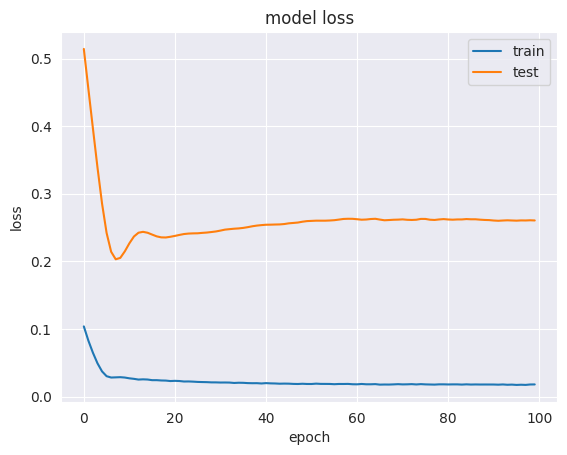

In [182]:

model = Sequential()
model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(8))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_Y, epochs=100, batch_size=70, validation_data=(validation_X, validation_Y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [177]:
# make a prediction
yhat = model.predict(test_X)
#test_X = test_X.reshape((test_X.shape[0], 16))

2/2 [==============================] - 1s 6ms/step


In [178]:
#values_train = prediction_values.index[0:train_size]
#values_validation = prediction_values.index[train_size:train_size+validation_size]
index_test = price_precipitation.index[train_size+validation_size:dataset_size]
#values_test[:,0].index = index_test
len(yhat[:,0])

63

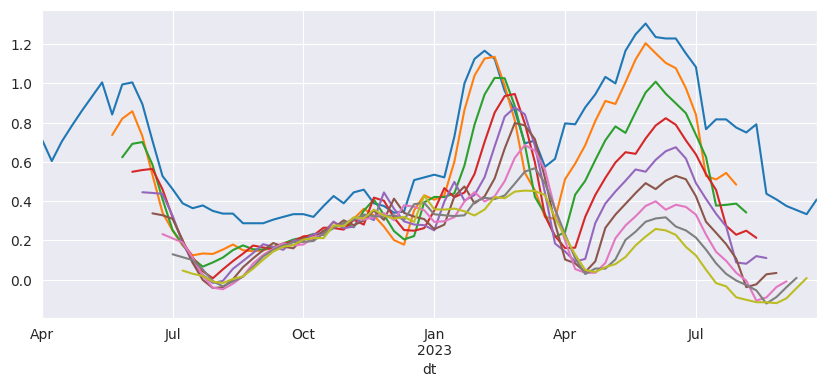

In [179]:

#pd.Series(yhat[:,0]).plot()
test_series = pd.Series(values_test[:,0], index=index_test)
pred_0 = pd.Series(yhat[:,0], index=index_test[7:len(yhat)+7])
pred_1 = pd.Series(yhat[:,1], index=index_test[8:len(yhat)+8])
pred_2 = pd.Series(yhat[:,2], index=index_test[9:len(yhat)+9])
pred_3 = pd.Series(yhat[:,3], index=index_test[10:len(yhat)+10])
pred_4 = pd.Series(yhat[:,4], index=index_test[11:len(yhat)+11])
pred_5 = pd.Series(yhat[:,5], index=index_test[12:len(yhat)+12])
pred_6 = pd.Series(yhat[:,6], index=index_test[13:len(yhat)+13])
pred_7 = pd.Series(yhat[:,7], index=index_test[14:len(yhat)+14])

plt.figure(figsize=(10, 4))
test_series.plot()
pred_0.plot()
pred_1.plot()
pred_2.plot()
pred_3.plot()
pred_4.plot()
pred_5.plot()
pred_6.plot()
pred_7.plot()
plt.show()

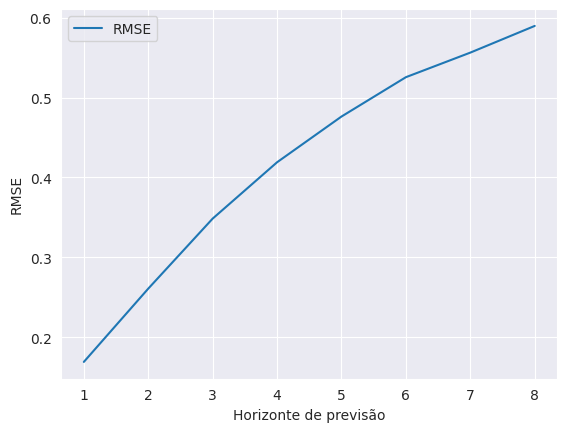

In [184]:

rmse_by_distance = [np.sqrt(mean_squared_error(test_series[7:len(pred_0)+7], pred_0)),
					np.sqrt(mean_squared_error(test_series[8:len(pred_1)+8], pred_1)),
					np.sqrt(mean_squared_error(test_series[9:len(pred_2)+9], pred_2)),
					np.sqrt(mean_squared_error(test_series[10:len(pred_3)+10], pred_3)),
					np.sqrt(mean_squared_error(test_series[11:len(pred_4)+11], pred_4)),
					np.sqrt(mean_squared_error(test_series[12:len(pred_5)+12], pred_5)),
					np.sqrt(mean_squared_error(test_series[13:len(pred_6)+13], pred_6)),
					np.sqrt(mean_squared_error(test_series[14:len(pred_7)+14], pred_7))]
rmses = pd.DataFrame(rmse_by_distance, index=[i+1 for i in range(8)], columns=['RMSE'])
rmses.plot()
plt.xlabel('Horizonte de previsão')
plt.ylabel('RMSE')
plt.show()
#pd.Series(test_Y[:,0]).plot()

In [185]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(test_Y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.415


In [111]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_Y = test_Y.reshape((len(test_Y), 1))
inv_y = np.concatenate((test_Y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
comparison_df = pd.DataFrame({'actual': inv_y, 'predicted': inv_yhat}, index=price_weather_df.index[train_size+validation_size:243])
comparison_df.plot()

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 3 dimension(s)

In [ ]:
#X = test_X[0, :].reshape((1, 1, test_X.shape[2]))
#next_y = model.predict(X)
#yhat = [next_y]

#for i in range(len(test_Y)-1):
#	X = np.concatenate((X[:, :, 1:], next_y.reshape((1, 1, 1))), axis=2)
#	next_y = model.predict(X)
#	yhat.append(next_y)

#yhat = np.array(yhat).reshape((len(yhat), 1))
#test_X = test_X.reshape((test_X.shape[0], 4))

# invert scaling for forecast
#inv_yhat = np.concatenate((yhat, test_X[:, -1:]), axis=1)
#inv_yhat = scaler.inverse_transform(inv_yhat)
#inv_yhat = inv_yhat[:,0]

# invert scaling for actual
#test_Y = test_Y.reshape((len(test_Y), 1))
#inv_y = np.concatenate((test_Y, test_X[:, -1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
#inv_y = inv_y[:,0]

# calculate RMSE
#rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
#print('Test RMSE: %.3f' % rmse)
#comparison_df = pd.DataFrame({'actual': inv_y, 'predicted': inv_yhat}, index=price_weather_df.index[train_size+validation_size:243])
#comparison_df.plot()